Opening bands with rasterio

In [16]:
import rasterio
file='20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif'
satdat=rasterio.open(file)
RED=satdat.read(3)
NIR=satdat.read(4)




Computation of NDVI and Storing in a TIF file

In [17]:
import numpy
numpy.seterr(divide='ignore', invalid='ignore')

NDVI=(NIR.astype(float)-RED.astype(float))/(NIR + RED)
print(numpy.nanmin(NDVI))
print(numpy.nanmax(NDVI))
print(numpy.nanmean(NDVI))
print(numpy.nanstd(NDVI))


meta=satdat.meta
# print(meta)
NDVI_type=NDVI.dtype
# print(NDVI_type)



kwargs=meta

kwargs.update(dtype=NDVI_type)
kwargs.update(count=1)
kwargs.update(driver='GTiff')

with rasterio.open('NDVI_PlanetScope_data/NDVIP.tif','w',**kwargs) as dst:
    dst.write(NDVI,1)

-0.0684326710816777
0.5683563748079877
0.11458065150662002
0.028273112912141997


file='20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif'
MEAN NDVI=0.11458065150662002
STANDARD DEVIATION=0.028273112912141997
MINIMUM NDVI=-0.0684326710816777
MAXIMUM NDVI=0.5683563748079877

Class written by Joe Kington to Normalize the colorbar.

In [18]:
from matplotlib import colors

# Credit: Joe Kington
class MidpointNormalize(colors.Normalize):
    """
    Normalize the colorbar so that diverging bars work there way either side from a prescribed midpoint value
    
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

Attaining the colormap plot

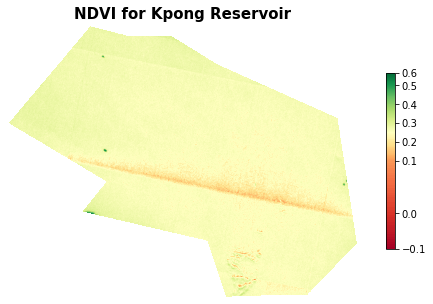

In [19]:
import matplotlib.pyplot as plt

min=numpy.nanmin(NDVI)
max=numpy.nanmax(NDVI)

mid=0.1
colormap=plt.cm.RdYlGn
norm= MidpointNormalize(vmin=min,vmax=max,midpoint=mid)
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
NDVI=NDVI.squeeze()
cbar_plot=ax.imshow(NDVI, cmap=colormap, norm=norm)
ax.axis('off')
cbar=fig.colorbar(cbar_plot,orientation='vertical',shrink=0.65)
ax.set_title('NDVI for Kpong Reservoir',fontsize=15,fontweight='bold')
fig.savefig("NDVI_PlanetScope_data/ndvip-fig",dpi=200,bbox_inches='tight',pad_inches=0.7)


Attaining the histogram plot

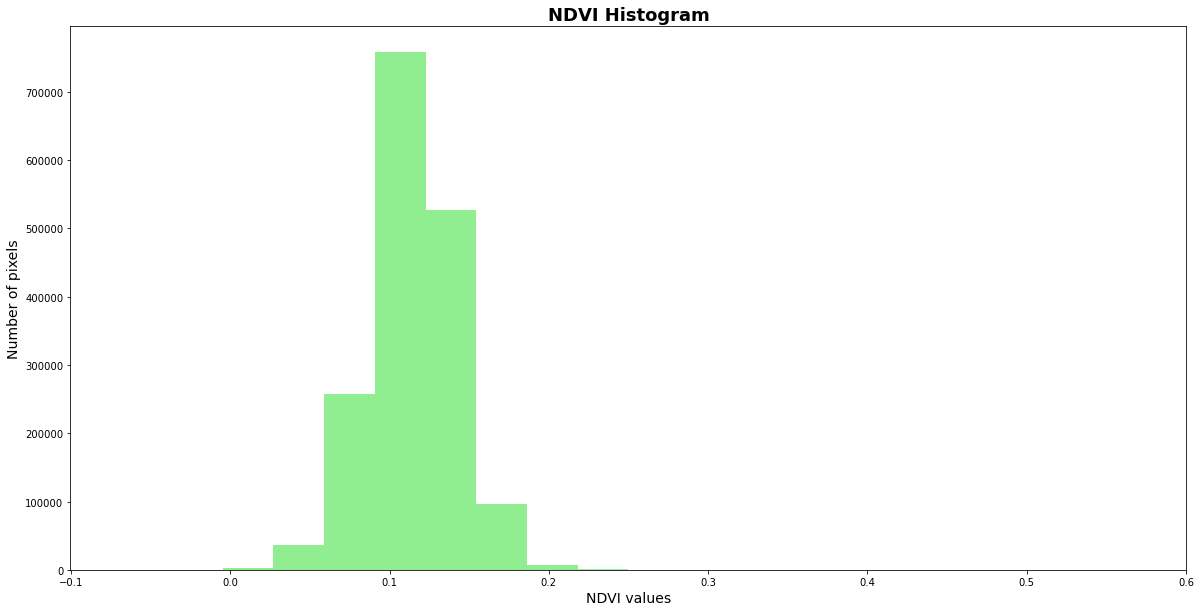

In [20]:
fig2 = plt.figure(figsize=(20,10))
ax = fig2.add_subplot(111)
plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)
x = NDVI[~numpy.isnan(NDVI)]
bins = 20
color = 'lightgreen'
ax.hist(x,bins,color=color)
fig2.savefig("NDVI_PlanetScope_data/ndvip-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

In [21]:
fig.savefig(r"C:\xampp\htdocs\SourceCode/ndvip-fig_20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif.png", dpi=200,bbox_inches='tight',pad_inches=0.7)
fig2.savefig(r"C:\xampp\htdocs\SourceCode/ndvip-histogram_20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif.png",dpi=200,bbox_inches='tight',pad_inches=0.7)



In [22]:
FigureName="ndvip-fig_20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif.png"
HistName="ndvip-histogram_20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif.png"


Sending Information to the Database

In [23]:
import mysql.connector
from mysql.connector import Error

In [24]:
x=0
try:
    connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

    
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
        x=x+1

except Error as e:
    print("Error while connecting to MySQL", e)

Connected to MySQL Server version  5.5.5-10.4.22-MariaDB
You're connected to database:  ('remotesensingdata',)


In [25]:
MinNDVI=float(numpy.nanmin(NDVI))
MaxNDVI=float(numpy.nanmax(NDVI))
MeanNDVI=float(numpy.nanmean(NDVI))
StdNDVI=float(numpy.nanstd(NDVI))
Id='20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif'

In [26]:
connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

cursor=connection.cursor()
cursor.execute("INSERT INTO presenceofhab (DatasetID, NDVIMean, NDVIMax, NDVIMin, NDVIStandardDeviation) VALUES(%s, %s, %s, %s, %s)", (Id,MeanNDVI,MaxNDVI,MinNDVI,StdNDVI))
connection.commit()
print(cursor.rowcount,"Record insert successfully in to Table")

cursor.close()

1 Record insert successfully in to Table


True

In [27]:
Id='20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif'
Figure='NDVI_PlanetScope_data/ndvip-fig.png'
Histogram='NDVI_PlanetScope_data/ndvip-histogram.png'

In [28]:
import mysql.connector
connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

def convertToBinaryData(filename):
    with open(filename,'rb') as file:
        binaryData=file.read()
    return binaryData

In [29]:
def INSERTPIC(ID,FIG,HIST,FIGNAME,HISTNAME):
    connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')
    C=connection.cursor()
    
    Figpic=convertToBinaryData(FIG)
    Histpic=convertToBinaryData(HIST)
    
    C.execute("INSERT INTO habimages (DatasetID,NDVIfig,NDVIHistogram,NDVIFigName,NDVIHistName) VALUES(%s,%s,%s,%s,%s)",(ID,Figpic,Histpic,FIGNAME,HISTNAME))
    
    connection.commit()
    print(C.rowcount,"Record insert successfully in to Table")

    C.close()

In [30]:
INSERTPIC(Id,Figure,Histogram,FigureName,HistName)

1 Record insert successfully in to Table
